In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als
from lenskit import topn
from lenskit.metrics.predict import rmse, mae

In [93]:
#Load data from Bollen et al., 2010
choice = pd.read_csv('co1_wide.csv')  


movie_cols = ['movie'+str(num) for num in range(1,21)] +['choice']
score_cols = ['score'+str(num) for num in range(1,21)]

movies_wide = choice[movie_cols + ['userid', 'condition']].rename(columns=dict(zip(movie_cols,list(range(1,21)))))
scores_wide = choice[score_cols + ['userid']].rename(columns=dict(zip(score_cols,list(range(1,21)))))

movies_long = movies_wide.melt(id_vars=['userid', 'condition', 'choice'], var_name='array_num', value_name='movieid')
scores_long = scores_wide.melt(id_vars=['userid'], value_vars=list(range(1,21)), var_name='array_num', value_name='score')

#create the cartesian product of all unique movies and users for subsequent join
unique_movies = list(pd.unique(movies_long['movieid']))
unique_users = list(pd.unique(movies_long['userid']))
index = pd.MultiIndex.from_product([unique_users, unique_movies], names = ["userid","movieid"])
movies_users_index = pd.DataFrame(index = index).reset_index()



movies = pd.merge(movies_users_index, movies_long, how='left', on=["userid", "movieid"])
movies_scores = pd.merge(movies, scores_long, how='left', on=["userid", "array_num"])

movies_scores['chose_movie'] = np.where(movies_scores['choice']==movies_scores['movieid'], 1, 0)

#problems due to NaN
dups=movies_scores.duplicated(keep=False)

#convert long form dataframe into format similar to ratings matrix
R_df_long = movies_scores[['userid', 'movieid', 'score']].dropna()#form for surprise

R_df_long['rating']=R_df_long['score']/10
R_df_long['item']=R_df_long['movieid'].str.split(pat="/", expand=True)[[3]].astype(int)

ratings=R_df_long[['userid', 'item', 'rating']]
ratings.columns=['user', 'item', 'rating']

In [182]:
#For our first model, we want the low rank representation to approximate our data as closely as possible (i.e., overfit the data). 
#This way, our "real" user factors come as close as possible to user factors that could reproduce the predictions
#from the MF algorithm in Bollen et al., 2010.
algo_als = als.BiasedMF(10, iterations=100,reg=0.0001, bias=False, rng_spec=1)

algo_als.fit(ratings)
preds_als = batch.predict(algo_als, ratings)


#print("RMSE for ALS: {}".format(rmse(preds_als['prediction'], preds_als['rating'])))

algo_als_hat = als.BiasedMF(10, iterations=3,reg=0.0001, bias=False, rng_spec=1)

algo_als_hat.fit(ratings)
preds_als_hat = batch.predict(algo_als_hat, ratings)


print("RMSE for ALS: {}".format(rmse(preds_als['prediction'], preds_als['rating'])))
print("RMSE for ALS hat: {}".format(rmse(preds_als_hat['prediction'], preds_als_hat['rating'])))

print("MAE for ALS: {}".format(mae(preds_als['prediction'], preds_als['rating'])))
print("MAE for ALS hat: {}".format(mae(preds_als_hat['prediction'], preds_als_hat['rating'])))


RMSE for ALS: 0.01660285426101378
RMSE for ALS hat: 0.2547659899443631
MAE for ALS: 0.005854656281398418
MAE for ALS hat: 0.12020732917684518


In [183]:
print("Summary statistics for 'actual' data...")
print("min")
print(preds_als.min())
print("\n")
print("max")
print(preds_als.max())
print("\n")
print("mean")
print(preds_als.mean())
print("\n")

print("Summary statistics for 'hat' data...")
print("min")
print(preds_als_hat.min())
print("\n")
print("max")
print(preds_als_hat.max())
print("\n")
print("mean")
print(preds_als_hat.mean())

Summary statistics for 'actual' data...
min
user          19.000000
item           1.000000
rating         2.400000
prediction     2.399999
dtype: float64


max
user           251.000000
item          3949.000000
rating           5.000000
prediction       5.014661
dtype: float64


mean
user           143.542056
item          1695.534579
rating           3.685159
prediction       3.685144
dtype: float64


Summary statistics for 'hat' data...
min
user          19.000000
item           1.000000
rating         2.400000
prediction     1.254292
dtype: float64


max
user           251.000000
item          3949.000000
rating           5.000000
prediction       5.763938
dtype: float64


mean
user           143.542056
item          1695.534579
rating           3.685159
prediction       3.673479
dtype: float64


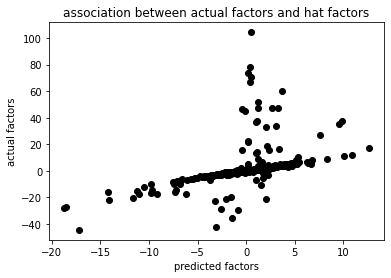

In [184]:
item_features=pd.DataFrame(algo_als.item_features_)
item_features_hat=pd.DataFrame(algo_als_hat.item_features_)
n_feature=0

item_hat = item_features[n_feature].tolist()
item_actual = item_features_hat[n_feature].tolist()

plt.plot(item_hat, item_actual, 'o', color='black');
plt.xlabel("predicted factors")
plt.ylabel("actual factors")
plt.title("association between actual factors and hat factors")

plt.show()